In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from tifffile import imread, imwrite
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Force reload modules
import importlib
import ppn2v.pn2v.gaussianMixtureNoiseModel
import ppn2v.pn2v.histNoiseModel
import ppn2v.pn2v.prediction
importlib.reload(ppn2v.pn2v.gaussianMixtureNoiseModel)
importlib.reload(ppn2v.pn2v.histNoiseModel)
importlib.reload(ppn2v.pn2v.prediction)

from ppn2v.pn2v import gaussianMixtureNoiseModel
from ppn2v.pn2v import histNoiseModel
from ppn2v.pn2v import prediction

Using device: cpu


### Load Model and Data

In [19]:
# Paths
path = './'
dataName = 'dataset01'

# Load images
clean_image = imread(path + f'{dataName}_clean.tif')
noisy_image = imread(path + f'{dataName}_noisy.tif')

# Handle 3D noisy image (1, H, W) -> (H, W)
if len(noisy_image.shape) == 3:
    noisy_image = noisy_image[0]

print(f"Clean image shape: {clean_image.shape}")
print(f"Noisy image shape: {noisy_image.shape}")

Clean image shape: (128, 128)
Noisy image shape: (128, 128)


In [20]:
# Select noise model (must match training)
# nameNoiseModel = f'HistNoiseModel_{dataName}_calibration'
nameNoiseModel = f'GMMNoiseModel_{dataName}_3_2_calibration'

print(f"Using noise model: {nameNoiseModel}")

Using noise model: GMMNoiseModel_dataset01_3_2_calibration


In [21]:
# Load trained network
net = torch.load(path + 'best_' + nameNoiseModel + '.net', weights_only=False)
print(f"Loaded network: best_{nameNoiseModel}.net")
print(f"Network output channels: {net.num_classes} samples")

Loaded network: best_GMMNoiseModel_dataset01_3_2_calibration.net
Network output channels: 800 samples


In [22]:
# Load noise model
if 'HistNoiseModel' in nameNoiseModel:
    histogram = np.load(path + nameNoiseModel + '.npy')
    noiseModel = histNoiseModel.NoiseModel(histogram, device=device)
    print("Loaded histogram noise model")
    
elif 'GMMNoiseModel' in nameNoiseModel:
    params = np.load(path + nameNoiseModel + '.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(
        params=params, device=device
    )
    print("Loaded GMM noise model")

Loaded GMM noise model


### Run Prediction

PN2V returns:
1. **Prior Mean (`means`)**: Simple average of samples (like N2V output)
2. **MMSE Estimate (`mseEst`)**: Weighted average using noise model likelihood
3. **All Samples**: For computing uncertainty (standard deviation)

In [23]:
# Reload noisy image fresh and ensure 2D
noisy_image = imread(path + f'{dataName}_noisy.tif')
noisy_image = np.squeeze(noisy_image)  # (1,128,128) -> (128,128)
print(f"Noisy image shape (fresh load): {noisy_image.shape}")

# Run prediction
print("\nRunning PN2V prediction...")

# For small images, use direct prediction instead of tiled
h, w = noisy_image.shape
tile_size = min(128, h, w)
overlap = min(24, tile_size // 4)

print(f"Using tile_size={tile_size}, overlap={overlap}")

if h <= 256 and w <= 256:
    # For small images, use direct prediction (no tiling)
    print("Small image detected - using direct prediction...")
    from ppn2v.pn2v.prediction import predict
    means, mseEst = predict(noisy_image, net, noiseModel, device, outScaling=10.0)
else:
    # For larger images, use tiled prediction
    means, mseEst = prediction.tiledPredict(
        noisy_image, 
        net,
        ps=tile_size,
        overlap=overlap,
        device=device,
        noiseModel=noiseModel
    )

print(f"\nPrediction complete!")
print(f"Prior mean shape: {means.shape}")
print(f"MMSE estimate shape: {mseEst.shape}")
print(f"MMSE range: [{mseEst.min():.2f}, {mseEst.max():.2f}]")

Noisy image shape (fresh load): (128, 128)

Running PN2V prediction...
Using tile_size=128, overlap=24
Small image detected - using direct prediction...

Prediction complete!
Prior mean shape: (128, 128)
MMSE estimate shape: (128, 128)
MMSE range: [71.80, 187.03]

Prediction complete!
Prior mean shape: (128, 128)
MMSE estimate shape: (128, 128)
MMSE range: [71.80, 187.03]


### Generate Uncertainty Map

The uncertainty map shows pixel-wise standard deviation of the posterior samples.
- **High uncertainty**: Regions where the model is less confident (potential defects, edges, fine details)
- **Low uncertainty**: Regions where the model is confident about the denoised value

This is the **key advantage** over supervisor's method!

In [24]:
# Reload noisy image fresh to ensure correct shape
noisy_for_uncertainty = imread(path + f'{dataName}_noisy.tif')
noisy_for_uncertainty = np.squeeze(noisy_for_uncertainty)  # (1,128,128) -> (128,128)
print(f"Noisy image for uncertainty: {noisy_for_uncertainty.shape}")

def compute_uncertainty_map(image, net, device):
    """
    Compute pixel-wise uncertainty (standard deviation of posterior samples).
    Works for any image size.
    """
    net.eval()
    
    # Ensure 2D input
    image = np.squeeze(np.array(image))
    if len(image.shape) != 2:
        raise ValueError(f"Expected 2D image, got shape {image.shape}")
    
    # Normalize input
    img_normalized = (image - net.mean) / net.std
    
    h, w = img_normalized.shape
    print(f"  Image shape: {h}x{w}")
    
    # Pad to multiple of 16 for U-Net compatibility
    pad_h = (16 - h % 16) % 16
    pad_w = (16 - w % 16) % 16
    img_padded = np.pad(img_normalized, ((0, pad_h), (0, pad_w)), mode='reflect')
    
    with torch.no_grad():
        # Prepare input tensor
        img_tensor = torch.from_numpy(img_padded[np.newaxis, np.newaxis, ...].astype(np.float32))
        img_tensor = img_tensor.to(device)
        
        # Get network output (all samples)
        output = net(img_tensor)
        print(f"  Network output shape: {output.shape}")
        
        samples = output.cpu().numpy()[0] * 10.0  # Undo output scaling
        samples = samples * net.std + net.mean    # Denormalize
        
        # Compute mean and std across samples dimension
        # samples shape: (n_samples, H, W)
        sample_mean = samples.mean(axis=0)
        sample_std = samples.std(axis=0)
        print(f"  Sample std shape: {sample_std.shape}")
    
    # Crop to original size
    uncertainty = sample_std[:h, :w]
    
    return uncertainty

print("Computing uncertainty map...")

uncertainty_map = compute_uncertainty_map(noisy_for_uncertainty, net, device)

print(f"\nUncertainty map computed!")
print(f"Shape: {uncertainty_map.shape}")
print(f"Range: [{uncertainty_map.min():.4f}, {uncertainty_map.max():.4f}]")
print(f"Mean uncertainty: {uncertainty_map.mean():.4f}")

Noisy image for uncertainty: (128, 128)
Computing uncertainty map...
  Image shape: 128x128
  Network output shape: torch.Size([1, 800, 128, 128])
  Sample std shape: (128, 128)

Uncertainty map computed!
Shape: (128, 128)
Range: [0.5392, 3.4172]
Mean uncertainty: 1.4378
  Network output shape: torch.Size([1, 800, 128, 128])
  Sample std shape: (128, 128)

Uncertainty map computed!
Shape: (128, 128)
Range: [0.5392, 3.4172]
Mean uncertainty: 1.4378


### Calculate Quality Metrics

In [1]:
# Reload images fresh to avoid any corruption from previous cells
clean_image_fresh = imread(path + f'{dataName}_clean.tif')
noisy_image_fresh = imread(path + f'{dataName}_noisy.tif')

# Debug: Check all shapes first
print("Fresh loaded shapes:")
print(f"  clean_image: {clean_image_fresh.shape}")
print(f"  noisy_image: {noisy_image_fresh.shape}")
print(f"  means: {means.shape}")
print(f"  mseEst: {mseEst.shape}")

# Ensure all images are 2D and same shape
def ensure_2d(img):
    """Squeeze to 2D, handling various input shapes."""
    img = np.array(img)
    # Remove all singleton dimensions
    img = np.squeeze(img)
    # If still not 2D, take first slice
    while len(img.shape) > 2:
        img = img[0]
    return img

clean_2d = ensure_2d(clean_image_fresh)
noisy_2d = ensure_2d(noisy_image_fresh)
means_2d = ensure_2d(means)
mmse_2d = ensure_2d(mseEst)

print(f"\nShapes after ensuring 2D:")
print(f"  Clean: {clean_2d.shape}")
print(f"  Noisy: {noisy_2d.shape}")
print(f"  Means: {means_2d.shape}")
print(f"  MMSE:  {mmse_2d.shape}")

# Verify all shapes match
assert clean_2d.shape == noisy_2d.shape == means_2d.shape == mmse_2d.shape, \
    f"Shape mismatch! clean={clean_2d.shape}, noisy={noisy_2d.shape}, means={means_2d.shape}, mmse={mmse_2d.shape}"

# Normalize all images to [0, 1] for fair comparison
def normalize_01(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-10)

clean_norm = normalize_01(clean_2d)
noisy_norm = normalize_01(noisy_2d)
means_norm = normalize_01(means_2d)
mmse_norm = normalize_01(mmse_2d)

# Calculate metrics
# Baseline (noisy vs clean)
psnr_noisy = psnr(clean_norm, noisy_norm, data_range=1.0)
ssim_noisy = ssim(clean_norm, noisy_norm, data_range=1.0)

# Prior mean (like N2V)
psnr_means = psnr(clean_norm, means_norm, data_range=1.0)
ssim_means = ssim(clean_norm, means_norm, data_range=1.0)

# MMSE estimate (PN2V best output)
psnr_mmse = psnr(clean_norm, mmse_norm, data_range=1.0)
ssim_mmse = ssim(clean_norm, mmse_norm, data_range=1.0)

print("\n" + "="*60)
print("QUALITY METRICS COMPARISON")
print("="*60)
print(f"{'Method':<25} {'PSNR (dB)':<12} {'SSIM':<10}")
print("-"*60)
print(f"{'Noisy (baseline)':<25} {psnr_noisy:<12.2f} {ssim_noisy:<10.4f}")
print(f"{'Prior Mean (N2V-like)':<25} {psnr_means:<12.2f} {ssim_means:<10.4f}")
print(f"{'MMSE Estimate (PN2V)':<25} {psnr_mmse:<12.2f} {ssim_mmse:<10.4f}")
print("-"*60)
print(f"{'Supervisor Benchmark':<25} {'28.48':<12} {'0.73':<10}")
print("="*60)

# Improvement over baseline
print(f"\nPSNR improvement over noisy: {psnr_mmse - psnr_noisy:.2f} dB")
print(f"SSIM improvement over noisy: {ssim_mmse - ssim_noisy:.4f}")



NameError: name 'imread' is not defined

### Visualize Results

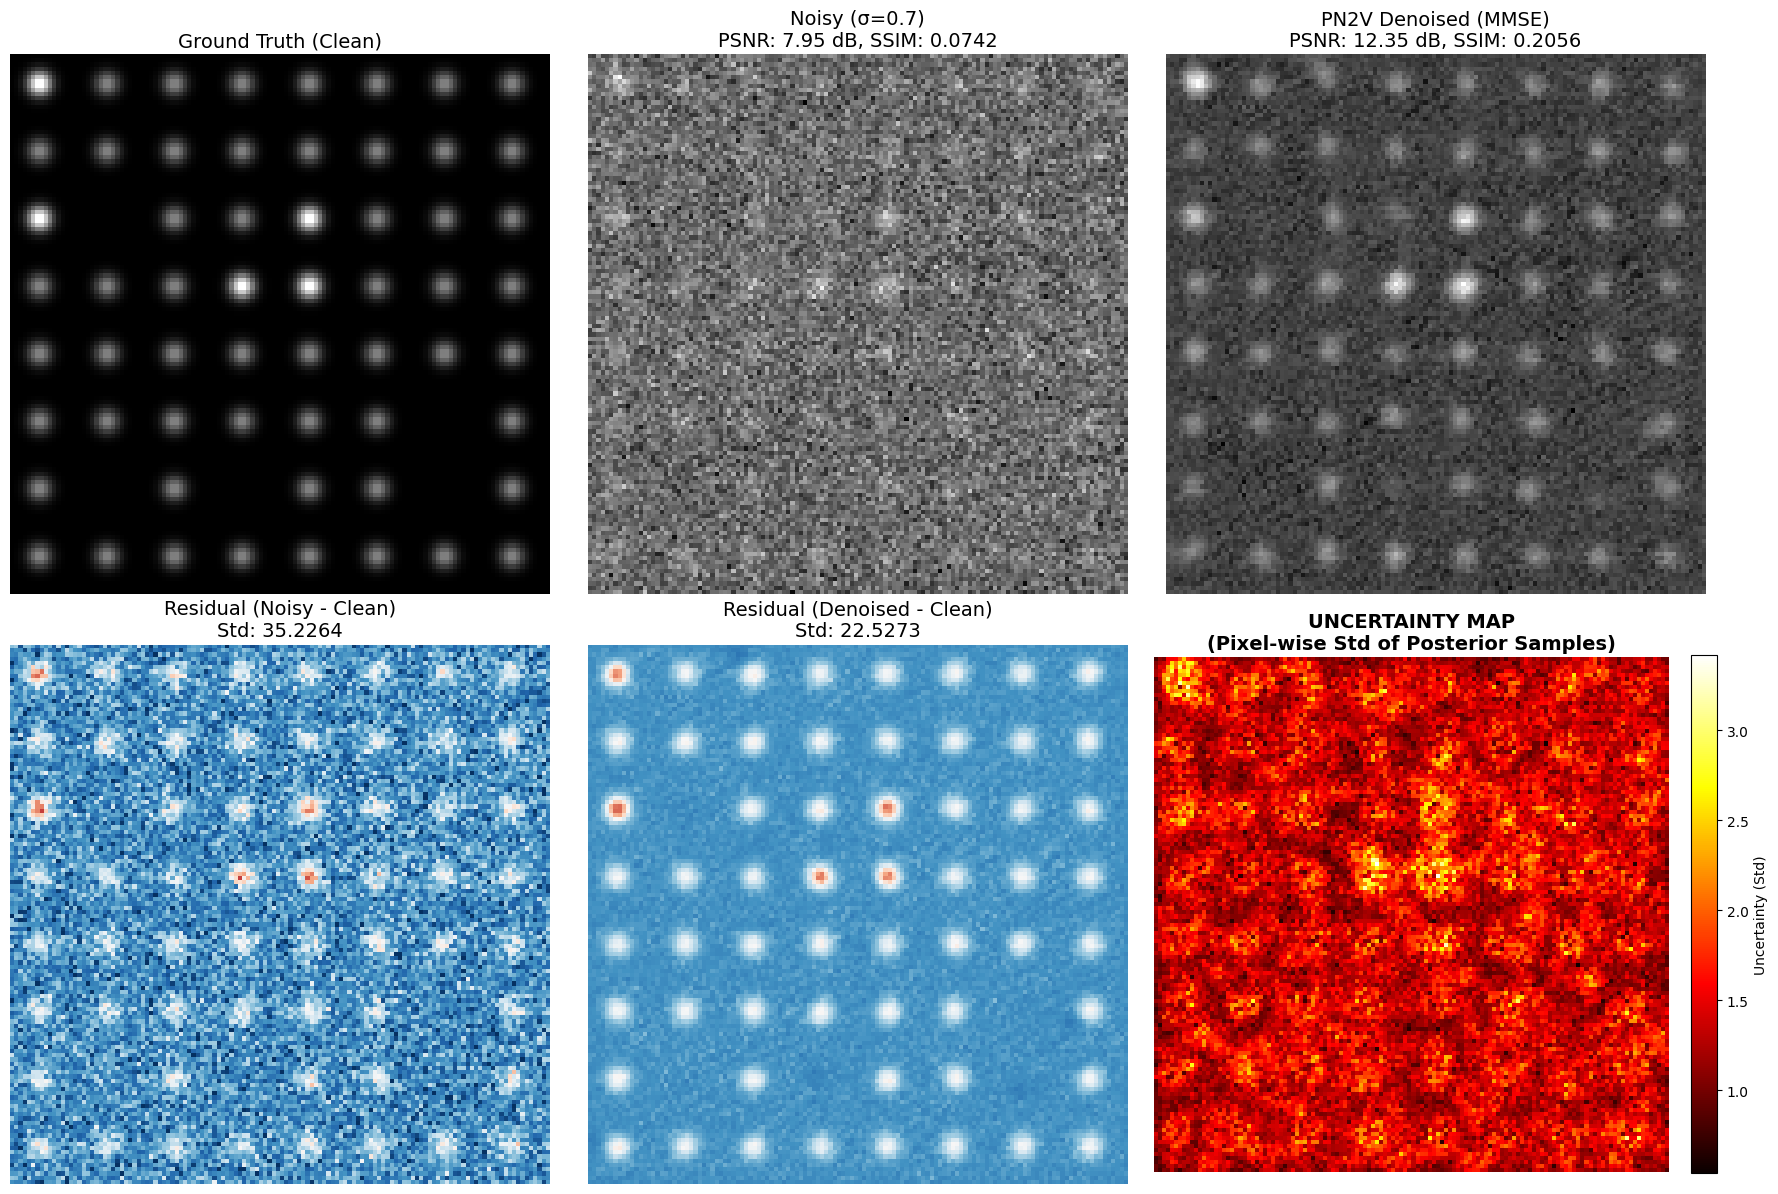


Figure saved: dataset01_results_comparison.png


In [26]:
# Use the 2D versions for visualization
clean_viz = clean_2d
noisy_viz = noisy_2d
mmse_viz = mmse_2d

# Main comparison figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Images
axes[0, 0].imshow(clean_viz, cmap='gray')
axes[0, 0].set_title('Ground Truth (Clean)', fontsize=14)
axes[0, 0].axis('off')

axes[0, 1].imshow(noisy_viz, cmap='gray')
axes[0, 1].set_title(f'Noisy (σ=0.7)\nPSNR: {psnr_noisy:.2f} dB, SSIM: {ssim_noisy:.4f}', fontsize=14)
axes[0, 1].axis('off')

axes[0, 2].imshow(mmse_viz, cmap='gray')
axes[0, 2].set_title(f'PN2V Denoised (MMSE)\nPSNR: {psnr_mmse:.2f} dB, SSIM: {ssim_mmse:.4f}', fontsize=14)
axes[0, 2].axis('off')

# Row 2: Residuals and Uncertainty
residual_noisy = noisy_viz - clean_viz
residual_denoised = mmse_viz - clean_viz
vmax = np.percentile(np.abs(residual_noisy), 99)

axes[1, 0].imshow(residual_noisy, cmap='RdBu', vmin=-vmax, vmax=vmax)
axes[1, 0].set_title(f'Residual (Noisy - Clean)\nStd: {residual_noisy.std():.4f}', fontsize=14)
axes[1, 0].axis('off')

axes[1, 1].imshow(residual_denoised, cmap='RdBu', vmin=-vmax, vmax=vmax)
axes[1, 1].set_title(f'Residual (Denoised - Clean)\nStd: {residual_denoised.std():.4f}', fontsize=14)
axes[1, 1].axis('off')

# Uncertainty map with colorbar
im = axes[1, 2].imshow(uncertainty_map, cmap='hot')
axes[1, 2].set_title('UNCERTAINTY MAP\n(Pixel-wise Std of Posterior Samples)', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')
plt.colorbar(im, ax=axes[1, 2], fraction=0.046, pad=0.04, label='Uncertainty (Std)')

plt.tight_layout()
plt.savefig(path + f'{dataName}_results_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved: {dataName}_results_comparison.png")

### Detailed Uncertainty Map Visualization

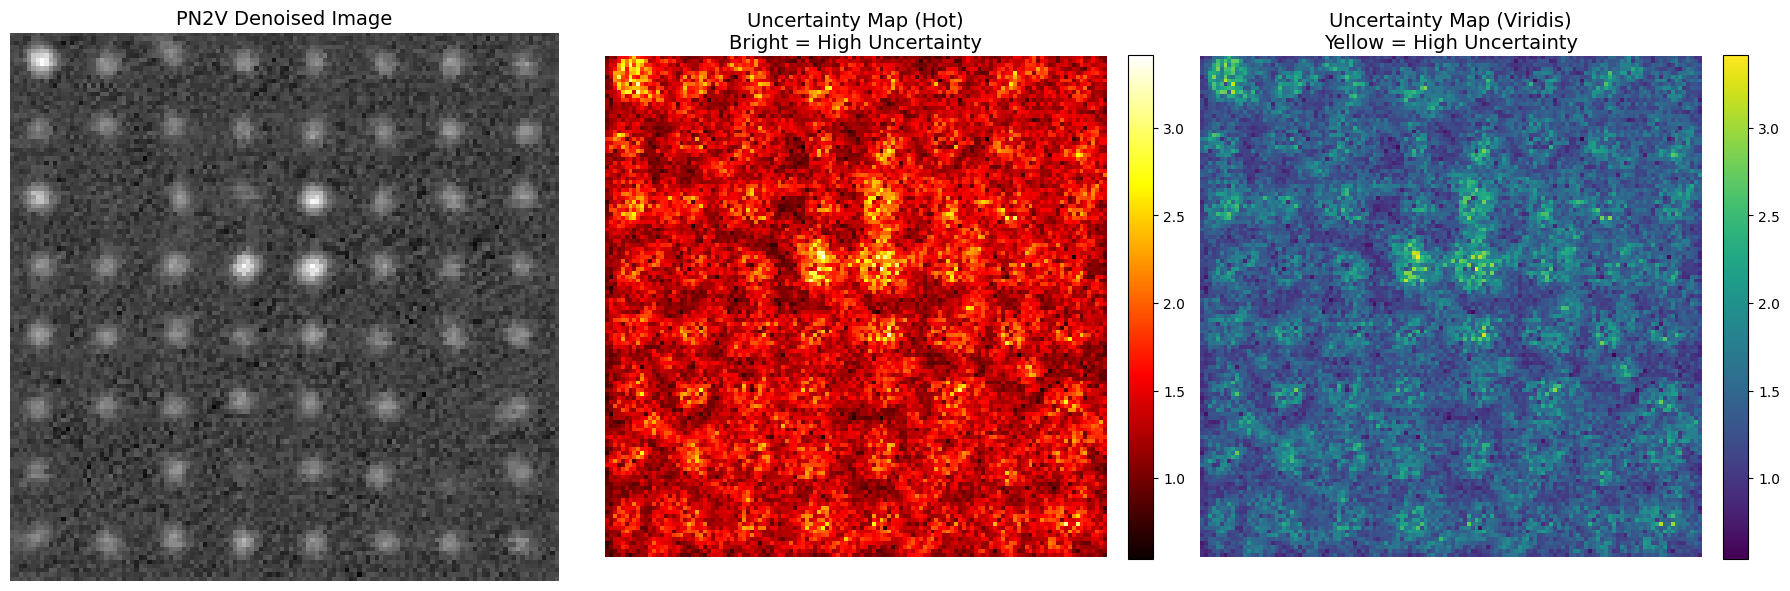

Uncertainty map saved: dataset01_uncertainty_map.png


In [27]:
# Dedicated uncertainty map figure (for supervisor)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Left: Denoised image
axes[0].imshow(mmse_2d, cmap='gray')
axes[0].set_title('PN2V Denoised Image', fontsize=14)
axes[0].axis('off')

# Middle: Uncertainty map (hot colormap)
im1 = axes[1].imshow(uncertainty_map, cmap='hot')
axes[1].set_title('Uncertainty Map (Hot)\nBright = High Uncertainty', fontsize=14)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Right: Uncertainty map (viridis colormap)
im2 = axes[2].imshow(uncertainty_map, cmap='viridis')
axes[2].set_title('Uncertainty Map (Viridis)\nYellow = High Uncertainty', fontsize=14)
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(path + f'{dataName}_uncertainty_map.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Uncertainty map saved: {dataName}_uncertainty_map.png")

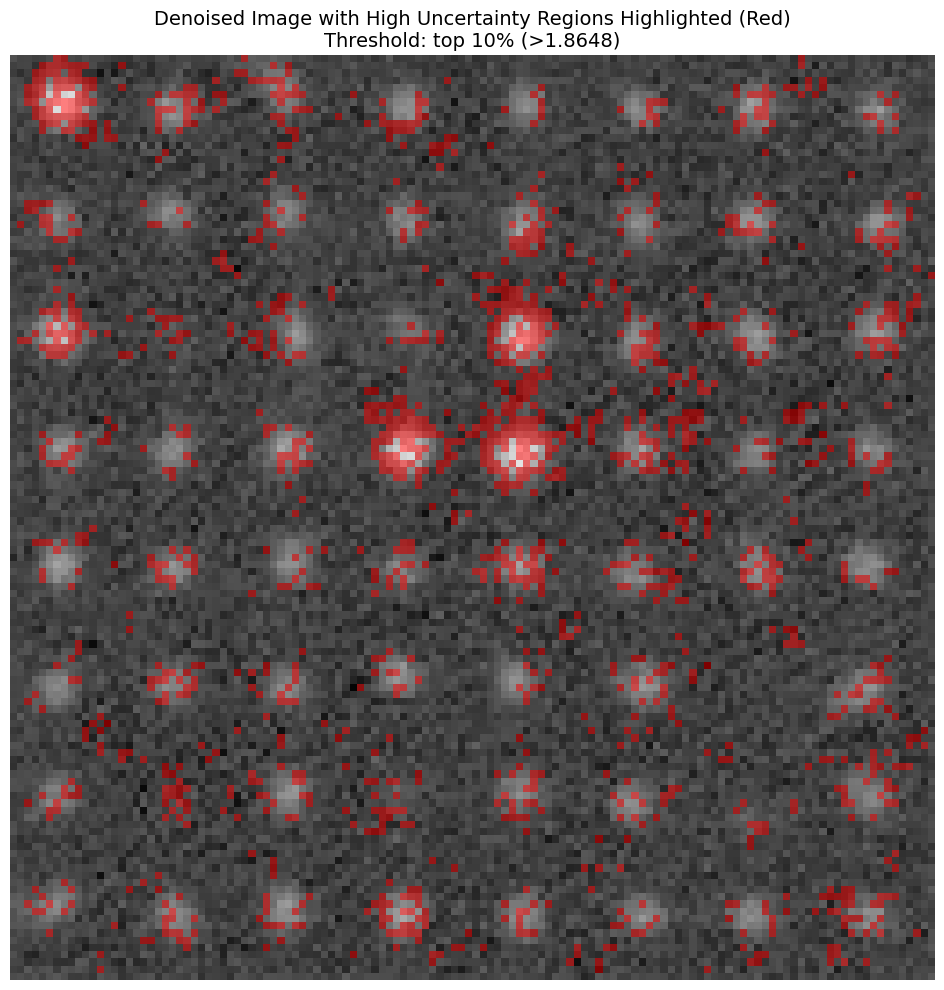

Overlay saved: dataset01_uncertainty_overlay.png


In [28]:
# Overlay: Denoised image with uncertainty highlights
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Show denoised image
ax.imshow(mmse_2d, cmap='gray')

# Overlay high uncertainty regions
threshold = np.percentile(uncertainty_map, 90)  # Top 10% uncertainty
high_uncertainty = uncertainty_map > threshold

# Create RGBA overlay
overlay = np.zeros((*uncertainty_map.shape, 4))
overlay[high_uncertainty] = [1, 0, 0, 0.5]  # Red with 50% transparency

ax.imshow(overlay)
ax.set_title(f'Denoised Image with High Uncertainty Regions Highlighted (Red)\n'
             f'Threshold: top 10% (>{threshold:.4f})', fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.savefig(path + f'{dataName}_uncertainty_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Overlay saved: {dataName}_uncertainty_overlay.png")

### Zoomed Comparison

Crop region: (42:74, 42:74), size: (32, 32)


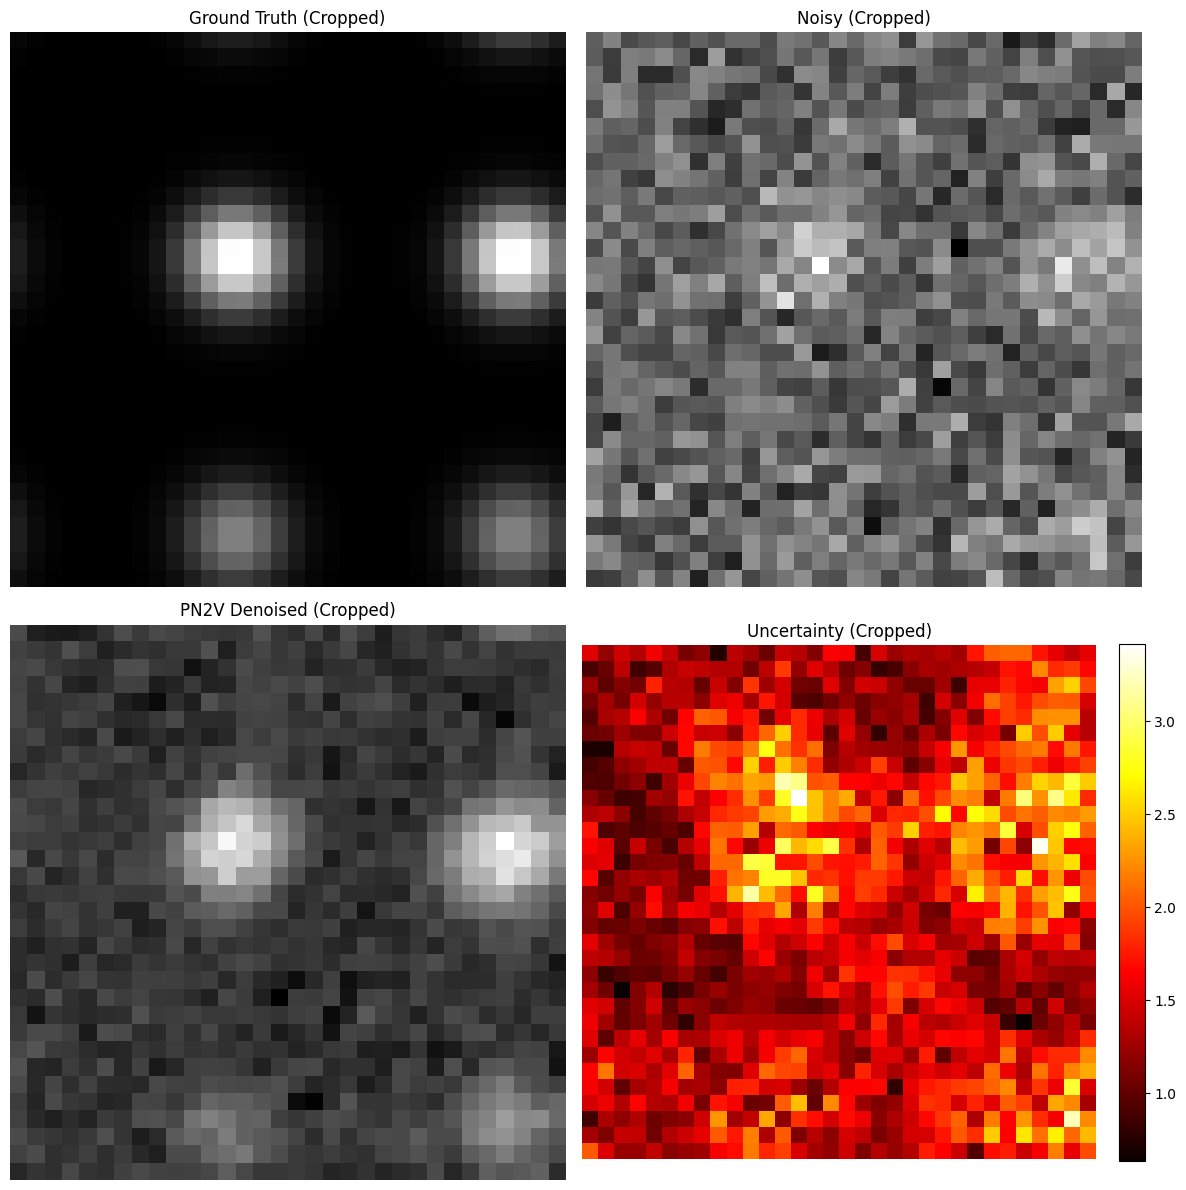

In [29]:
# Select region of interest for detailed comparison
h, w = clean_2d.shape
crop_size = max(32, min(64, h//4, w//4))  # Ensure at least 32x32 crop
y_start, x_start = h//3, w//3

# Ensure crop doesn't exceed image bounds
y_end = min(y_start + crop_size, h)
x_end = min(x_start + crop_size, w)

# Crop all images
clean_crop = clean_2d[y_start:y_end, x_start:x_end]
noisy_crop = noisy_2d[y_start:y_end, x_start:x_end]
denoised_crop = mmse_2d[y_start:y_end, x_start:x_end]
uncertainty_crop = uncertainty_map[y_start:y_end, x_start:x_end]

print(f"Crop region: ({y_start}:{y_end}, {x_start}:{x_end}), size: {clean_crop.shape}")

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(clean_crop, cmap='gray')
axes[0, 0].set_title('Ground Truth (Cropped)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(noisy_crop, cmap='gray')
axes[0, 1].set_title('Noisy (Cropped)', fontsize=12)
axes[0, 1].axis('off')

axes[1, 0].imshow(denoised_crop, cmap='gray')
axes[1, 0].set_title('PN2V Denoised (Cropped)', fontsize=12)
axes[1, 0].axis('off')

im = axes[1, 1].imshow(uncertainty_crop, cmap='hot')
axes[1, 1].set_title('Uncertainty (Cropped)', fontsize=12)
axes[1, 1].axis('off')
plt.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig(path + f'{dataName}_zoomed_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Save Results

In [30]:
# Save denoised images and uncertainty map
imwrite(path + f'{dataName}_denoised_prior_mean.tif', means.astype(np.float32))
imwrite(path + f'{dataName}_denoised_mmse.tif', mseEst.astype(np.float32))
imwrite(path + f'{dataName}_uncertainty_map.tif', uncertainty_map.astype(np.float32))

print("Saved TIFF files:")
print(f"  - {dataName}_denoised_prior_mean.tif")
print(f"  - {dataName}_denoised_mmse.tif")
print(f"  - {dataName}_uncertainty_map.tif")

# Save metrics to text file
with open(path + f'{dataName}_metrics.txt', 'w') as f:
    f.write("PN2V Denoising Results for DATASET_01\n")
    f.write("="*50 + "\n\n")
    f.write(f"Target noise level: σ=0.7\n\n")
    f.write("Quality Metrics:\n")
    f.write("-"*50 + "\n")
    f.write(f"{'Method':<25} {'PSNR (dB)':<12} {'SSIM':<10}\n")
    f.write("-"*50 + "\n")
    f.write(f"{'Noisy (baseline)':<25} {psnr_noisy:<12.2f} {ssim_noisy:<10.4f}\n")
    f.write(f"{'Prior Mean':<25} {psnr_means:<12.2f} {ssim_means:<10.4f}\n")
    f.write(f"{'MMSE Estimate (PN2V)':<25} {psnr_mmse:<12.2f} {ssim_mmse:<10.4f}\n")
    f.write("-"*50 + "\n")
    f.write(f"{'Supervisor Benchmark':<25} {'28.48':<12} {'0.73':<10}\n")
    f.write("="*50 + "\n\n")
    f.write(f"PSNR improvement over noisy: {psnr_mmse - psnr_noisy:.2f} dB\n")
    f.write(f"SSIM improvement over noisy: {ssim_mmse - ssim_noisy:.4f}\n")

print(f"\nMetrics saved: {dataName}_metrics.txt")

Saved TIFF files:
  - dataset01_denoised_prior_mean.tif
  - dataset01_denoised_mmse.tif
  - dataset01_uncertainty_map.tif


UnicodeEncodeError: 'charmap' codec can't encode character '\u03c3' in position 20: character maps to <undefined>

### Key Outputs
1. **Denoised Images:**
   - `dataset01_denoised_mmse.tif` - Main result
   - `dataset01_denoised_prior_mean.tif` - N2V-like output

2. **Uncertainty Map:**
   - `dataset01_uncertainty_map.tif` - Pixel-wise confidence
   - High values indicate unreliable predictions (potential defects, edges)

3. **Visualizations:**
   - `dataset01_results_comparison.png` - Main comparison figure
   - `dataset01_uncertainty_map.png` - Detailed uncertainty visualization
   - `dataset01_uncertainty_overlay.png` - Denoised + uncertainty overlay

### Advantages of PN2V over Supervisor's Method
1. **Uncertainty quantification** - Identifies unreliable predictions
2. **Higher model capacity** (64 channels vs 4) without hallucinations
3. **Principled probabilistic framework** - Better noise handling
4. **Self-supervised** - No need for paired clean data during training